In [1]:
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dcekit.validation import mae_cce
from sklearn import datasets
from sklearn.cross_decomposition import PLSRegression
from sklearn.datasets import load_boston, make_regression
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
dataset = load_boston()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.Series(dataset.target, name='MEDV')

/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Calif

In [35]:
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.model_selection import train_test_split, GridSearchCV

number_of_test_samples = 200
fold_number = 5

# load dataset
boston = load_boston()
y = boston.target
x = boston.data

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=number_of_test_samples, random_state=0)
autoscaled_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
autoscaled_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)

class GPR:
    def __init__(self, X_train, X_test, y_train, y_test, autoscaled_X_train):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.autoscaled_X_train = autoscaled_X_train
        self.autoscaled_X_test = autoscaled_X_test
        
    def gpr(self):
        kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
                   ConstantKernel() * RBF() + WhiteKernel(),
                   ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
                   ConstantKernel() * RBF(np.ones(X_train.shape[1])) + WhiteKernel(),
                   ConstantKernel() * RBF(np.ones(X_train.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
                   ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
                   ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
                   ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
                   ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
                   ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
                   ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]
    
        # Gaussian process regression
        cv_model = GridSearchCV(GaussianProcessRegressor(alpha=0), {'kernel': kernels}, cv=fold_number)
        cv_model.fit(autoscaled_X_train, autoscaled_y_train)
        optimal_kernel = cv_model.best_params_['kernel']
        self.model = GaussianProcessRegressor(optimal_kernel, alpha=0)
        self.model.fit(autoscaled_X_train, autoscaled_y_train)
        return self.model
    
    def calcurate(self):
        model = self.gpr()
        # calculate y in training data
        calculated_y_train = model.predict(autoscaled_X_train) * y_train.std(ddof=1) + y_train.mean()
        # yy-plot
        plt.rcParams['font.size'] = 18  # 横軸や縦軸の名前の文字などのフォントのサイズ
        plt.figure(figsize=figure.figaspect(1))
        plt.scatter(y_train, calculated_y_train, c='blue')
        y_max = np.max(np.array([np.array(y_train), calculated_y_train]))
        y_min = np.min(np.array([np.array(y_train), calculated_y_train]))
        plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
                 [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
        plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlabel('Actual Y')
        plt.ylabel('Calculated Y')
        plt.show()
        # r2, RMSE, MAE
        print('r2: {0}'.format(float(1 - sum((y_train - calculated_y_train) ** 2) / sum((y_train - y_train.mean()) ** 2))))
        print('RMSE: {0}'.format(float((sum((y_train - calculated_y_train) ** 2) / len(y_train)) ** 0.5)))
        print('MAE: {0}'.format(float(sum(abs(y_train - calculated_y_train)) / len(y_train))))
    
    def prediction(self):
        model = self.gpr()
        # prediction
        predicted_y_test, predicted_y_test_std = model.predict(autoscaled_X_test, return_std=True)
        predicted_y_test = predicted_y_test * y_train.std(ddof=1) + y_train.mean()
        predicted_y_test_std = predicted_y_test_std * y_train.std(ddof=1)
        # yy-plot
        plt.figure(figsize=figure.figaspect(1))
        plt.scatter(y_test, predicted_y_test, c='blue')
        y_max = np.max(np.array([np.array(y_test), predicted_y_test]))
        y_min = np.min(np.array([np.array(y_test), predicted_y_test]))
        plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
                 [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
        plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
        plt.xlabel('Actual Y')
        plt.ylabel('Predicted Y')
        plt.show()
        # r2p, RMSEp, MAEp
        print('r2p: {0}'.format(float(1 - sum((y_test - predicted_y_test) ** 2) / sum((y_test - y_test.mean()) ** 2))))
        print('RMSEp: {0}'.format(float((sum((y_test - predicted_y_test) ** 2) / len(y_test)) ** 0.5)))
        print('MAEp: {0}'.format(float(sum(abs(y_test - predicted_y_test)) / len(y_test))))
        print('')
    
        plt.scatter(predicted_y_test_std, abs(y_test - predicted_y_test), c='blue')
        plt.xlabel('Std. of estimated Y')
        plt.ylabel('Error of Y')
        plt.show()

/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Calif

/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/hiroto/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  Con

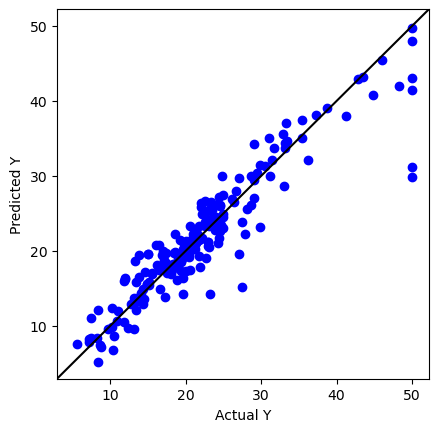

r2p: 0.8648368898398958
RMSEp: 3.3242570634590924
MAEp: 2.126387489422716



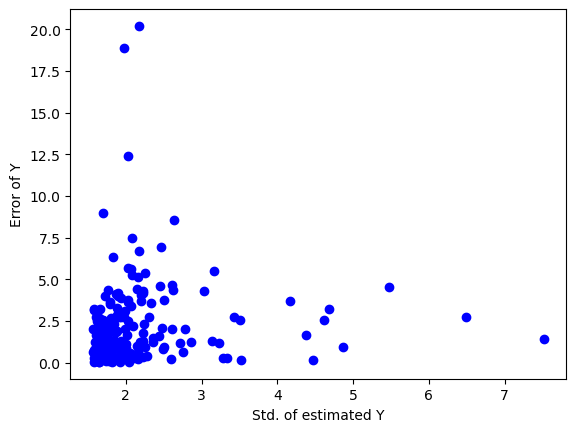

In [36]:
GPR(X_train, X_test, y_train, y_test, autoscaled_X_train).prediction()

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, DotProduct, WhiteKernel, RBF, ConstantKernel
from dcekit.variable_selection import cvpfi
from sklearn.datasets import load_boston, make_regression
from sklearn.model_selection import GridSearchCV, train_test_split

dataset = load_boston()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.Series(dataset.target, name='MEDV')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=0)

class CVPFI:
    def __init__(self, X_train, y_train, model):
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
   
    def regression(self, n_repeats=5, alpha_r=0.999, number_of_important_x=X_train.shape[1]):
        """
        settings
        * the number of repetition
        * alpha (the significance level) in the r (correlation) consideration, 1 means the correlations between features are not considered
        """
        autoscaled_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
        autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)

        fold_number = X_train.shape[0]

        numbers_of_x = list(range(X_train.shape[1]))
        numbers_of_y = [X_train.shape[1]]
        
        model = self.model
        model.fit(autoscaled_X_train, autoscaled_y_train)

        # CVPFI calculation
        self.importances_mean, self.importances_std, self.importances = cvpfi(
            model,
            autoscaled_X_train,
            autoscaled_y_train,
            fold_number=fold_number,
            scoring='r2',
            n_repeats=n_repeats,
            alpha_r=alpha_r,
            random_state=9,
        )
        
    @property
    def importances_(self):
        importances = {
            "importances_columns": X_train.columns, 
            "importances_mean": self.importances_mean, 
            "importances_std" : self.importances_std, 
            "importances": self.importances
            }
        return importances
    
    @property
    def plot_(self):
        number_of_important_x=X_train.shape[1]
        plt.rcParams['font.size'] = 16
        plt.bar(range(1, number_of_important_x + 1), self.importances_mean[range(0, number_of_important_x)], tick_label=X_train.columns[0:number_of_important_x], color='crimson', width=1)
        plt.bar(range(number_of_important_x + 1, X_train.shape[1] + 1), self.importances_mean[range(number_of_important_x, X_train.shape[1])], color='k', width=1)
        plt.xlabel('x')
        plt.xlabel('feature number')
        plt.xticks(rotation=70)
        plt.ylabel('importance')
        plt.show()

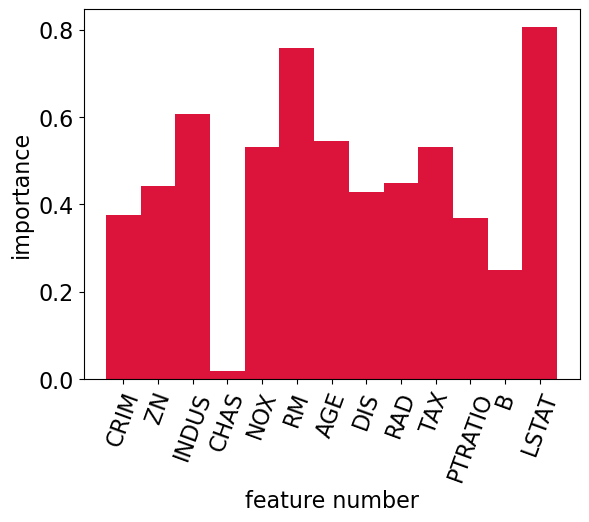

{'importances_columns': Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PTRATIO', 'B', 'LSTAT'],
       dtype='object'),
 'importances_mean': array([0.37474512, 0.44192192, 0.60603581, 0.01795841, 0.53105165,
        0.75709636, 0.54553695, 0.42785414, 0.44944691, 0.53125561,
        0.36810572, 0.24854916, 0.80651873]),
 'importances_std': array([0.03926576, 0.04246907, 0.03374457, 0.01253518, 0.04358802,
        0.0527795 , 0.04077006, 0.03609527, 0.04599564, 0.0513999 ,
        0.03549477, 0.02333971, 0.03545611]),
 'importances': array([[0.39227348, 0.42803022, 0.36275653, 0.36927789, 0.32138747],
        [0.40776951, 0.4130901 , 0.47356897, 0.50074303, 0.41443797],
        [0.57318599, 0.62475559, 0.60516646, 0.65234269, 0.5747283 ],
        [0.02597136, 0.00194987, 0.01911836, 0.03327862, 0.00947386],
        [0.57649642, 0.46074549, 0.55444768, 0.52714575, 0.53642292],
        [0.67905406, 0.79962827, 0.76672102, 0.73251942, 0.80755902],
 

In [38]:
model = GaussianProcessRegressor(ConstantKernel() * RBF() + WhiteKernel(), alpha=0) 
pfi = CVPFI(X_train, y_train, model)
pfi.regression()
pfi.plot_
pfi.importances_

In [1]:
class sim:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def calc(self):
        self.ab = self.a + self.b
    
    @property
    def prop_(self):
        ab = self.ab
        return ab

In [2]:
test = sim(3, 4)

In [3]:
test.calc()

In [4]:
test.prop_

7

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

17.5**2 * RBF(length_scale=1.45)

In [63]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

In [64]:
y_test = pd.DataFrame(y_test)

In [65]:
y_pred = pd.DataFrame(mean_prediction, columns=["MEDV"])

In [66]:
y_pred.index = y_test.index

In [5]:
plt.scatter(y_test, y_pred)
y_max = np.max(np.array([np.array(y_test), y_pred]))
y_min = np.min(np.array([np.array(y_test), y_pred]))
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))

NameError: name 'y_pred' is not defined

ValueError: x and y must be the same size

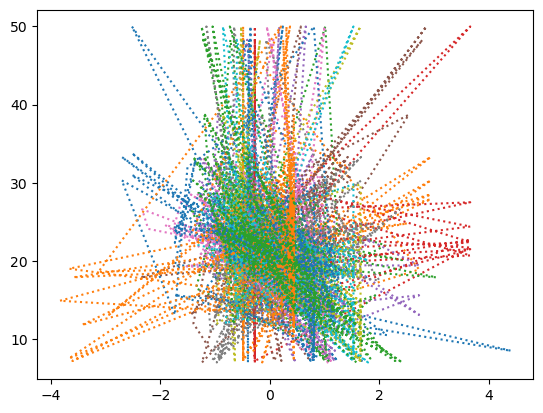

In [68]:
plt.plot(X_test, y_test, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X_test, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on noise-free dataset")